In [1]:
from kaggle_secrets import UserSecretsClient
!pip install wandb
import wandb
user_secrets = UserSecretsClient()
secret_hf = user_secrets.get_secret("HUGGINGFACE_TOKEN")
secret_wandb = user_secrets.get_secret("wandb")
!huggingface-cli login --token $secret_hf
wandb_api = user_secrets.get_secret("wandb") 
wandb.login(key=wandb_api)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.


Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git


In [3]:
import pandas as pd
import numpy as np
from datasets import Dataset, load_dataset

In [4]:
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM, Trainer, TrainingArguments, BitsAndBytesConfig
from peft import LoraConfig, AutoPeftModelForCausalLM, prepare_model_for_kbit_training, get_peft_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
dataset = load_dataset("BevenRozario/job_desc_5k")

# Accessing the train and validation datasets
train_dataset = dataset['train_dataset']
eval_dataset = dataset['eval_dataset']

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/BevenRozario--job_desc_5k-3d63b85cb90728c8/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
train_dataset[0]


{'Instruction': 'Generate a job description for a Social Media Manager role.The candidate should have skills in Social media analytics tools example Google Analytics, Facebook Insights Data analysis and reporting Social media ROI measurement Competitive analysis Trend identification. The job description should include the sector (Biotechnology) and industry (Pharmaceuticals) of the company.',
 'Response': 'Job Description: Social Media Manager (Pharmaceuticals - Biotechnology)\n\nWe are currently seeking a skilled and experienced Social Media Manager to join our team in the Pharmaceuticals industry, specializing in the Biotechnology sector. As a Social Media Manager, you will be responsible for analyzing social media data and user behavior to generate actionable insights. You will also track key performance indicators and recommend optimization strategies to enhance our social media presence. It is crucial for the ideal candidate to possess a profound understanding of Social Media Anal

In [7]:
def formatting_func(example):
    text = f"### Question: {example['Instruction']}\n ### Answer: {example['Response']}"
    return text

In [8]:
base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [9]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [10]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

  0%|          | 0/4500 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

In [11]:
tokenized_train_dataset['Instruction'][0]

'Generate a job description for a Social Media Manager role.The candidate should have skills in Social media analytics tools example Google Analytics, Facebook Insights Data analysis and reporting Social media ROI measurement Competitive analysis Trend identification. The job description should include the sector (Biotechnology) and industry (Pharmaceuticals) of the company.'

5000


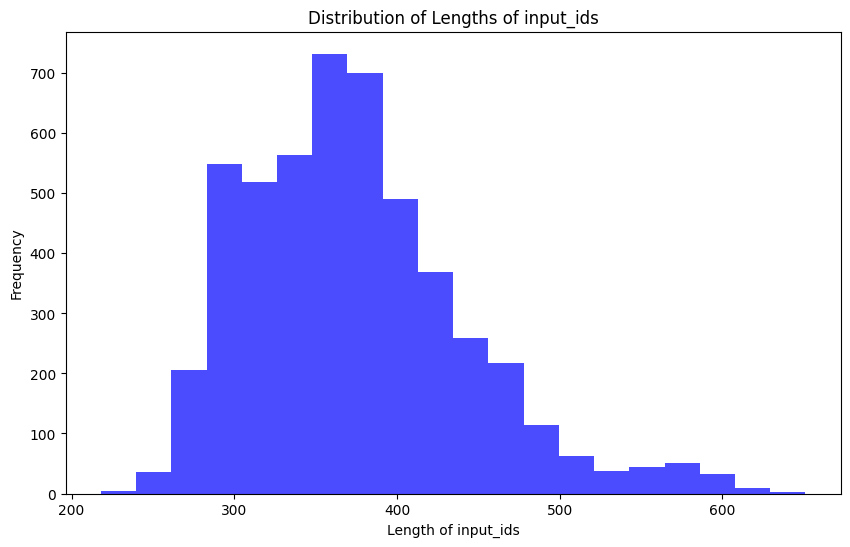

In [12]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [13]:
max_length = 600 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [14]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

  0%|          | 0/4500 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

In [15]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [16]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [17]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

In [18]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=2,
    target_modules=[
        "q_proj",
        "v_proj",
    ],
    bias="none",
    lora_dropout=0.2,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 3407872 || all params: 3755479040 || trainable%: 0.09074400266124238


In [19]:
print(model)


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.2, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=

In [20]:
from huggingface_hub import notebook_login

notebook_login()

In [21]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [22]:
import transformers
from datetime import datetime

project = "jobdesp-finetune-v2"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=2,
        gradient_checkpointing=True,
        num_train_epochs = 1,
#         max_steps=1350,
        learning_rate=1e-5, # Want a small lr for finetuning
        fp16=True,
        optim="paged_adamw_8bit",
        logging_steps=50,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=450,                # Save checkpoints every 450 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=450,               # Evaluate and save checkpoints every 450 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}",        # Name of the W&B run (optional)
        push_to_hub=True,  # Add this line to push the model to the hub,
        hub_model_id="BevenRozario/mistral_v3_5k"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()
trainer.push_to_hub()


wandb: Currently logged in as: bevv (bev-codes). Use `wandb login --relogin` to force relogin


wandb: wandb version 0.16.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: Tracking run with wandb version 0.16.1


wandb: Run data is saved locally in /kaggle/working/wandb/run-20240117_211137-w9ee6gun
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run mistral-jobdesp-finetune-v2-2024-01-17-21-11


wandb: ⭐️ View project at https://wandb.ai/bev-codes/huggingface


wandb: 🚀 View run at https://wandb.ai/bev-codes/huggingface/runs/w9ee6gun


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
450,1.041800,1.011664


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
